## Introduction

[Dask](https://dask.org/) is a Python library suited for block-wise parallelization of most Numpy and Pandas tasks. It is also useful for performing operations on out-of-memory data by automating the processing of paging chunks to and from storage. While there is a wonderful [tutorial](https://github.com/dask/dask-tutorial) available on GitHub, it does not show off some of the more interesting capabilities of Dask. The purpose of this notebook is to demonstrate how to use the `map_overlap` function to downscale an out-of-memory volumetric (3D) image. That being said, this notebook will make more sense if you go through the tutorial first.

### More Details

The way Dask operates is by creating a lazily-evaluated, directed acyclic graph of all the tasks its needs to perform to carry out its instructions, and assigning tasks in the correct order to workers in a distributed environment. What that means is that Dask doesn't do any computation until data is actually needed, or instructed directly by the `.compute()` method. The acyclic directed task graph part means that Dask figures out the order of operations necessary to perform what you've asked it to do and what operations depend on what other operations, and sets them up following the logic of the code you've written. Acyclic means that there can't be any cycles, which means no while loops and no recursion. When Dask is explicitly (via `.compute()`) or implicitly (via `.imshow()`, etc.) instructed to perform computations, the workers are assigned tasks from the task graph in the order indicated.

It is possible to visualize the task graph using `.visualize()`. The method is not used in this notebook because the task graphs are large and difficult to see in the drawing. The tutorial referenced above is a good source for more information. Progress of the tasks may be visualized on the task graph using the real-time dashboard, which will be explained closer to where it is set up.

### Library Imports and Helper Functions

Here we import packages and set up a couple of useful helper functions for downstream computations.

In [1]:
import dask
import dask.array as da
import numpy as np

In [2]:
def compute_mem_mb(shape):
    '''Determines memory consumption of an array with shape in MB'''
    from functools import reduce
    from operator import mul
    count = reduce(mul, shape, 1)
    return count * 8 / ( 1024 ** 2 )

def display(image):
    '''Shows an image in the Jupyter notebook.'''
    from skimage import io
    io.imshow(image)
    io.show()

def throughput(mem_mb, time_s):
    print("MB/s: {:.2f}".format(mem_mb / time_s))

def stats_da(image):
    print("Min: {min:.2f}\nMax: {max:.2f}\nMean: {mean:.2f}\nStd: {std:.2f}".format(
        max=image.max().compute(),
        min=image.min().compute(),
        mean=image.mean().compute(),
        std=image.std().compute()))

def stats_np(image):
    print("Min: {min:.2f}\nMax: {max:.2f}\nMean: {mean:.2f}\nStd: {std:.2f}".format(
        max=image.max(),
        min=image.min(),
        mean=image.mean(),
        std=image.std()))

def slice_axis(image, axis, position):
    """Retrieves a planar slice from image at position along axis."""
    sl = [slice(None)] * image.ndim
    sl[axis] = position
    return image[tuple(sl)]

def scale_shape(shape, factor):
    '''Gives the expected shape if scaled by factor'''
    return tuple(map(lambda x: round(x * factor), shape))

def rescale(chunk, factor, order=0):
    '''Rescales a chunk based on scaling factor.'''
    from skimage.transform import rescale
    return rescale(chunk, factor, order=order, multichannel=False)

def mean_downscale(chunk, factors):
    '''Resizes a chunk using the integer-factor local-mean downscaling from scikit-image'''
    from skimage.transform import downscale_local_mean
    return downscale_local_mean(chunk, factors)

### Distibuted Client and Dashboard Setup

As mentioned earler, Dask comes with a helpful real-time dashboard for understanding how tasks are distributed to workers. The dashboard is useful for developing intuition about parallel code performance. More information is available in the Dask tutorial, linked in the introduction at the top of the notebook. Below we set up the Dask distributed client and get a URL for the dashboard.

In [3]:
from dask.distributed import Client
c = Client()
port = c.scheduler_info()['services']['dashboard']
print("Type `http://localhost:{port}` into the URL bar of your favorite browser to watch the following code in action on your machine in real time.".format(port=port))

Type `http://localhost:8787` into the URL bar of your favorite browser to watch the following code in action on your machine in real time.


## Computation

### Preparation

Here we prepare some basic constants for downstream computation, like volumetric image size and chunk size. If at any point you receive any error messages about running out of memory on workers, reduce the chunk size. Feel free to play around with these values and re-run the notebook. It is recommended to follow along with the dashboard in your browser, see above for more information. Keep in mind that chunks can't be larger than the shape. Chunks that are too small will create significant overhead in the task graph and require more communication between workers, reducing efficiency. Chunks that are too large may consume too much memory.

In [5]:
ndim = 3
size_len = 400
size = ndim * [size_len]
mem_mb = compute_mem_mb(size)
print("3D array size (MB): {:.2f}".format(mem_mb))
chunk_len = 100
chunks = ndim * [chunk_len]
chunk_mem_mb = compute_mem_mb(chunks)
print("Chunk size (MB): {:.2f}".format(chunk_mem_mb))

3D array size (MB): 488.28
Chunk size (MB): 7.63


Here we create a vaguely interesting array of values which increase radially from the origin. To do this, we use the `da.indices()` function to create a collection of Dask arrays whose values are equal to their index. One array is created per dimension, giving us three arrays in the volumetric case.

We then stack the three arrays using `da.stack()` along the fourth dimension (`axis=3`) to create a 3D array of coordinate vectors.

To create the radial image we square every element, sum along the fourth dimension to add up the squares along the coordinate dimension (`axis=3` again), and then find the square root of every element.

Finally we normalize the array values by the maximum value over the entire array.

The construct `t = %timeit -n1 -r1 -o -q fn()` is IPython magic which means:
 - `%timeit`: time `fn()` on this line only...
 - `-n1`: looping one time...
 - `-r1`: repeating loops one time...
 - `-o`: output a value (and assign to `t`)...
 - `-q`: silently.

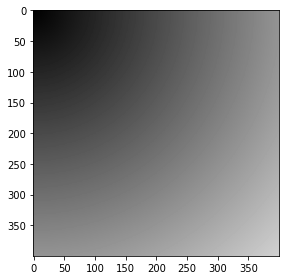

MB/s: 20.48


In [6]:
coords = da.indices(size, dtype='float', chunks=chunks)
grid = da.stack(coords, axis=3)
base_image = (grid ** 2).sum(axis=3) ** 0.5
image = base_image / base_image.max()
t = %timeit -n1 -r1 -o -q display(image[(None, 0)].squeeze())
throughput(mem_mb, t.average)

Here we generate some image statistics.

In [7]:
t = %timeit -n1 -r1 -o -q stats_da(image)
throughput(mem_mb, t.average)

Min: 0.00
Max: 1.00
Mean: 0.55
Std: 0.16
MB/s: 42.62


Image Slicing

Here we extract 2D planar slices of the volume image. The slices are parallel to the coordinate axis planes. They could be used for display, image analysis, or deep learning.

In [15]:
spacing = size_len // 5
x_images = np.stack([slice_axis(image, 0, x) for x in range(0, image.shape[0], spacing)])
y_images = np.stack([slice_axis(image, 1, x) for x in range(0, image.shape[1], spacing)])
z_images = np.stack([slice_axis(image, 2, x) for x in range(0, image.shape[2], spacing)])

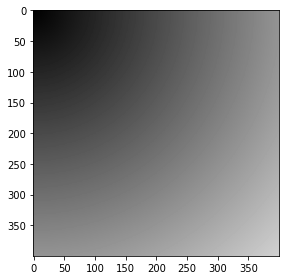

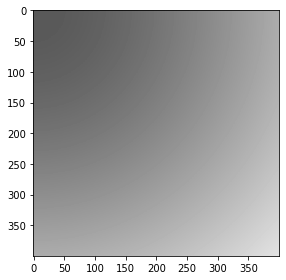

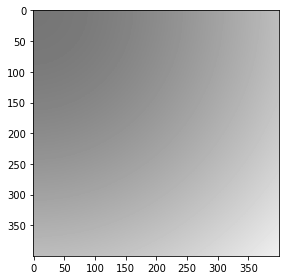

In [16]:
display(x_images[0])
display(y_images[3])
display(z_images[-1])